In [1]:
import osmnx as ox
import geopandas as gpd
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Preparing the OD Matrices

## 1. Splitting the OD Matrix

In [2]:
od_matrix = pd.read_csv('../data/d02_processed-safegraph/weeks_od_us_fua.csv')

First we will split the od_matrix into multiple dataframes based on the FUA area:

In [3]:
od_matrix_dict = {fua: df.reset_index(drop=True) for fua, df in od_matrix.groupby('fuacode')}

## 2. Removing Centroids that are outside the buffered FUA:

Safegraph sometimes report patterns that are not daily commutes. That is, for our purposes, commutes that cross the boundary of the FUA. Because of how the data was collected (selecting POIs inside the FUA), the only case in which this happens is for centroids lying outside the FUA boundaries. We see this represented in the following picture of FUA 80:

In [4]:
def get_points(od_matrix, to_crs=None, as_gdf=True):
    
    places_pt = gpd.points_from_xy(x= od_matrix.longitude, y=od_matrix.latitude, crs='EPSG:4326')
    centroids_pt = gpd.points_from_xy(x= od_matrix.intptlon, y=od_matrix.intptlat, crs='EPSG:4326')

    if to_crs is not None:
        places_pt = places_pt.to_crs(to_crs)
        centroids_pt = centroids_pt.to_crs(to_crs)
        
    if as_gdf:
        places_pt = gpd.GeoDataFrame(od_matrix[['safegraph_place_id', 'top_category']], geometry=places_pt)
        centroids_pt = gpd.GeoDataFrame(od_matrix[['census_block_group']], geometry=centroids_pt)
        
    return places_pt, centroids_pt

buffered_boundary_80 = gpd.read_file('../data/d03_intermediate/FUA-buffered-shapefile/FUA-buffered.shp').set_index('fuacode').loc[['USA80']]
drive_graph_80 = ox.load_graphml('../data/d03_intermediate/FUA-networks/drive/USA80.graphml')
OD_matrix_80 = od_matrix_dict['USA80']

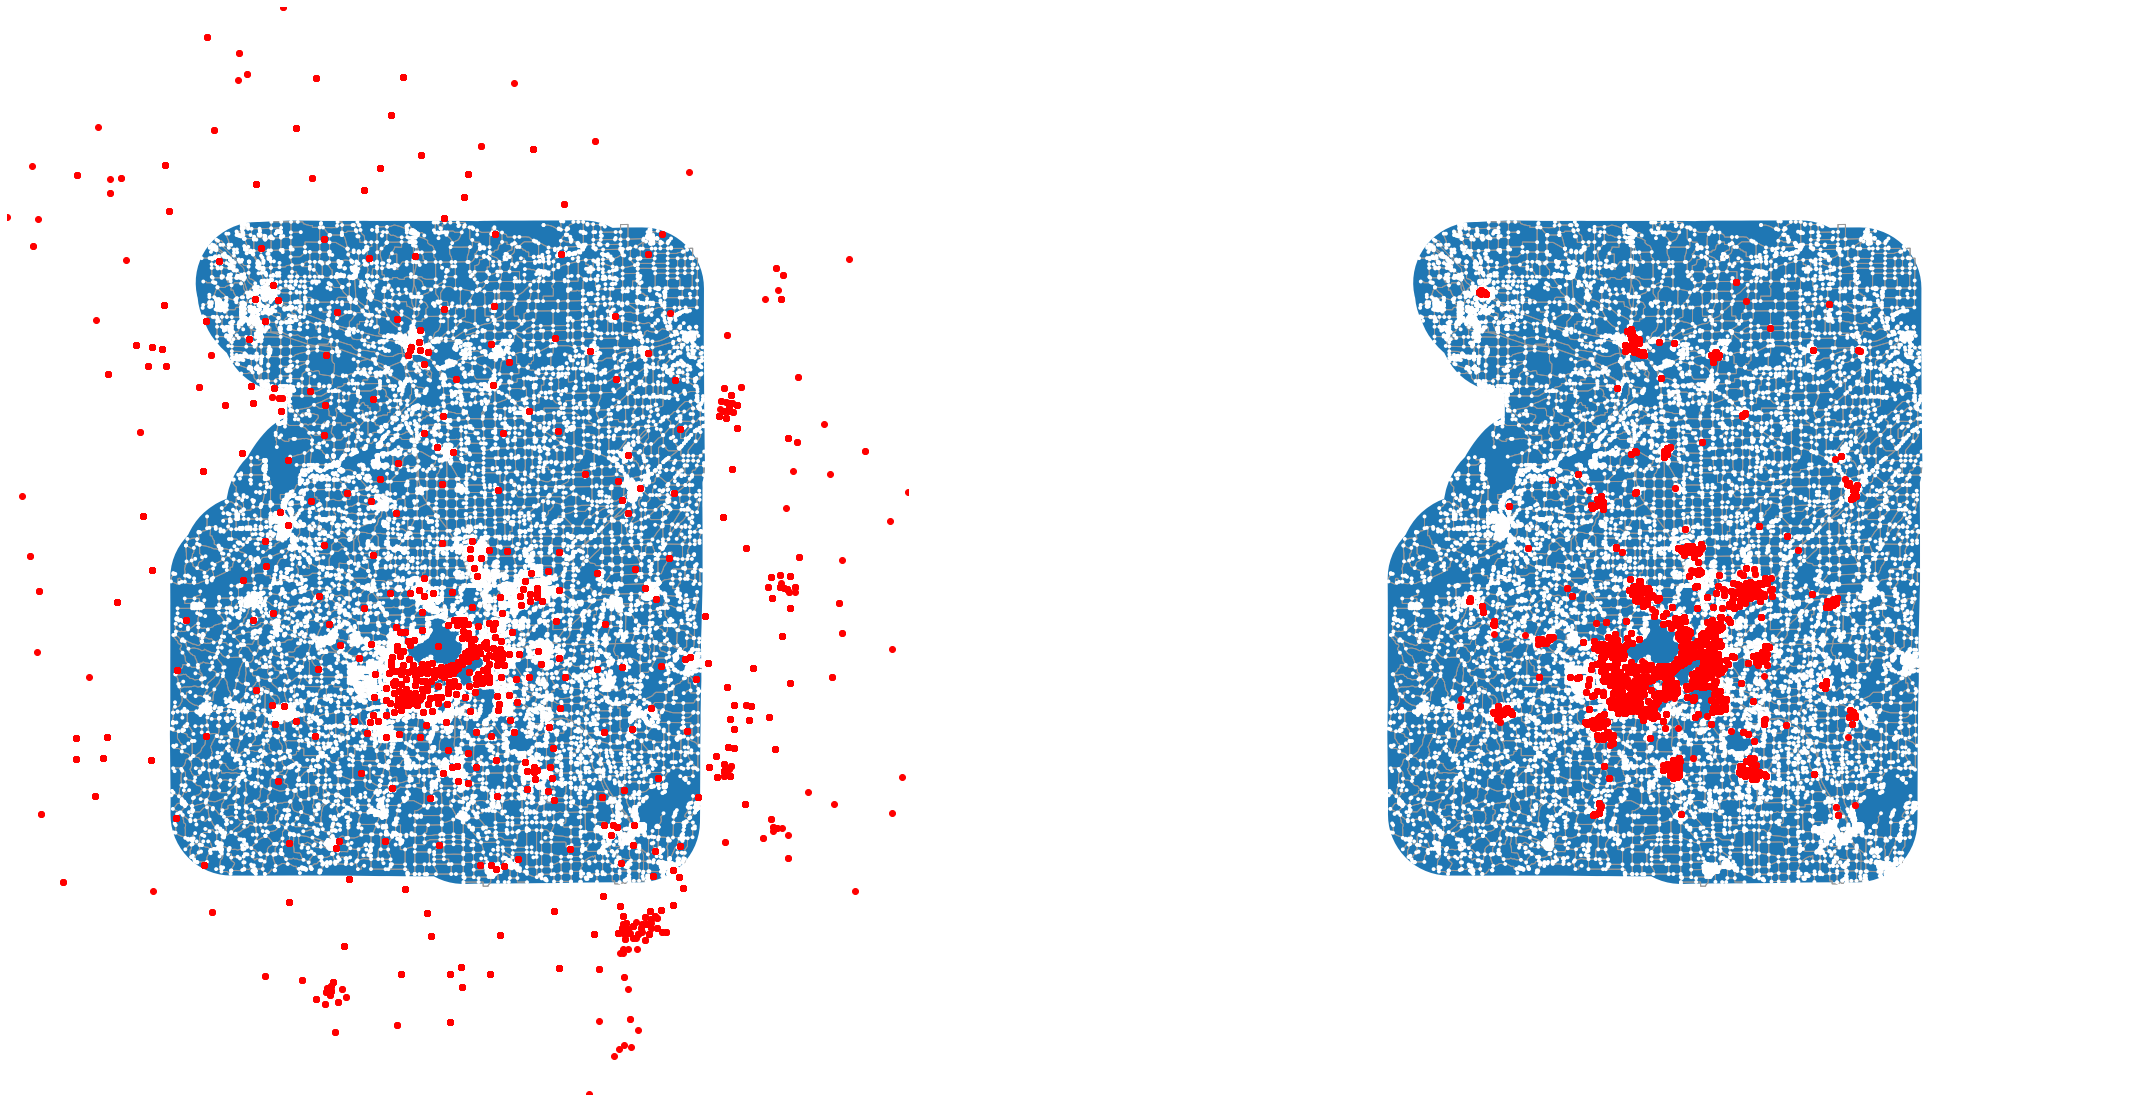

In [5]:
places_80, centroids_80 = get_points(OD_matrix_80)
w, s, e, n = centroids_80.geometry.total_bounds

fig, Axes = plt.subplots(figsize=(40,20), ncols=2)

ax1 = buffered_boundary_80.plot(ax=Axes[0])
ax1 = ox.plot_graph(drive_graph_80, ax=ax1, close=False, show=False, bbox=(n, s, e, w))[1]
ax1 = centroids_80.plot(c='red', ax=ax1)

ax2 = buffered_boundary_80.plot(ax=Axes[1])
ax2 = ox.plot_graph(drive_graph_80, ax=ax2, close=False, show=False, bbox=(n, s, e, w))[1]
ax2 = places_80.plot(c='red', ax=ax2)

plt.show()

The left graph (centroids) has plenty of points outside the boundary. The right graph (POIs) only has points inside 10km within the boundary (i.e. the original boundary). We want to trim all the OD matrices to exclude rows of commutes whose centroids fall outside the boundary.

In [6]:
def trim_centroids(od_matrix, buffered_boundary, bdry_as_gdf=True):
    
    if bdry_as_gdf:
        buffered_boundary = buffered_boundary.geometry[0]
    
    centroids_pt = gpd.points_from_xy(x= od_matrix.intptlon, y=od_matrix.intptlat, crs='EPSG:4326')
    rows_to_keep = centroids_pt.within(buffered_boundary)
    trimmed_od_matrix = od_matrix[rows_to_keep].reset_index(drop=True)

    return trimmed_od_matrix

In [7]:
trimmed_od_matrix_80 = trim_centroids(OD_matrix_80, buffered_boundary_80)

Checking that this worked:

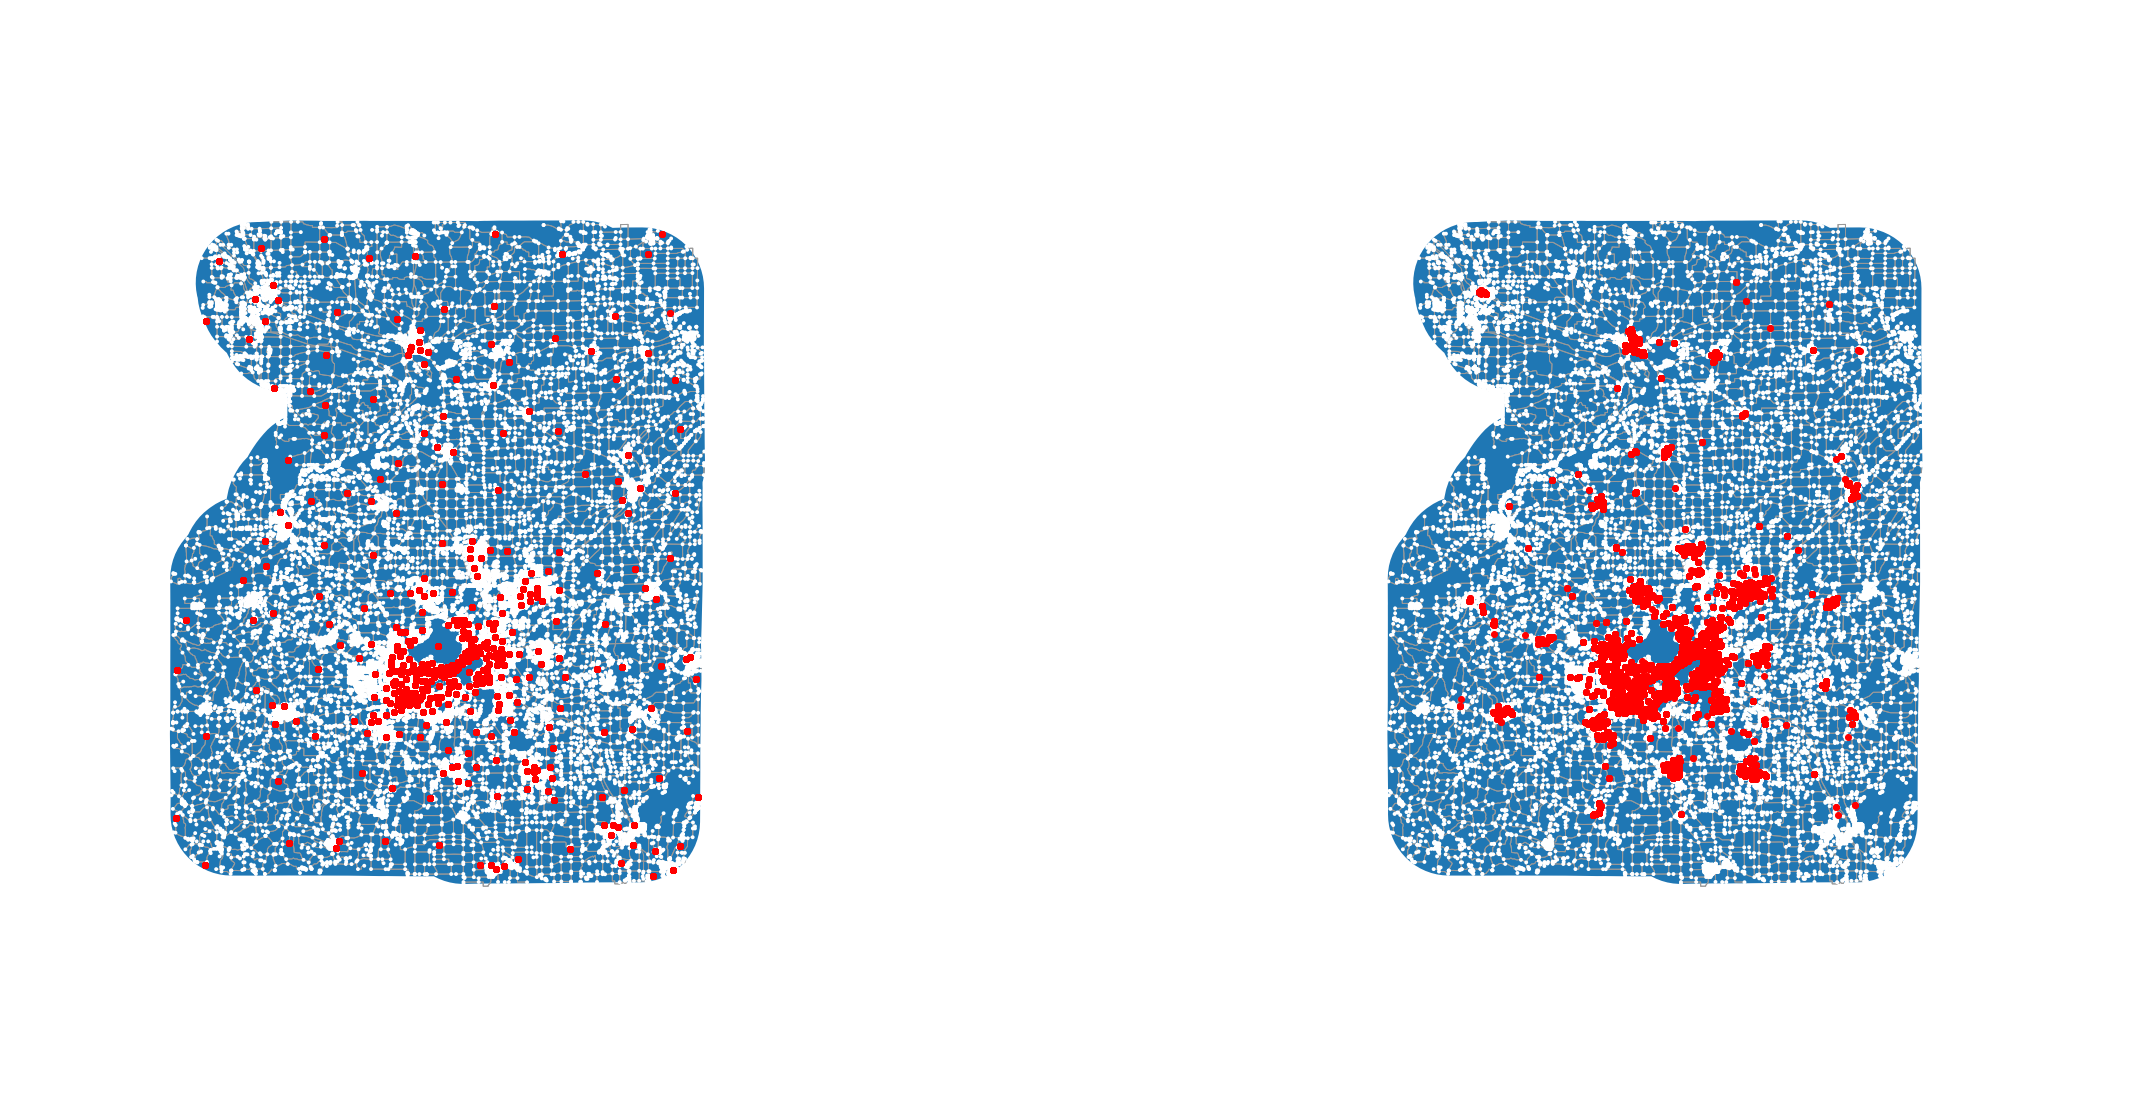

In [8]:
trimmed_places_80, trimmed_centroids_80 = get_points(trimmed_od_matrix_80)

fig, Axes = plt.subplots(figsize=(40,20), ncols=2)

ax1 = buffered_boundary_80.plot(ax=Axes[0])
ax1 = ox.plot_graph(drive_graph_80, ax=ax1, close=False, show=False, bbox=(n, s, e, w))[1]
ax1 = trimmed_centroids_80.plot(c='red', ax=ax1)

ax2 = buffered_boundary_80.plot(ax=Axes[1])
ax2 = ox.plot_graph(drive_graph_80, ax=ax2, close=False, show=False, bbox=(n, s, e, w))[1]
ax2 = trimmed_places_80.plot(c='red', ax=ax2)

plt.show()

Awesome! Now we can do it to all matrices and save them to file (done on cluster via the get-prepared-OD-matrix script):

In [ ]:
fua_buffered_boundaries = gpd.read_file('../data/d03_intermediate/FUA-buffered-shapefile/FUA-buffered.shp').set_index('fuacode')

for fua_code, od_matrix in tqdm(od_matrix_dict.items(), total=len(od_matrix_dict)):
    buffered_boundary = fua_buffered_boundaries.loc[[fua_code]]
    trimmed_od = trim_centroids(od_matrix, buffered_boundary)
    trimmed_od.to_csv('../data/d02_processed-safegraph/trimmed-OD-per-FUA/' + fua_code+'_trimmed-ODmatrix.csv')

## 3. Get all the Safegraph Represented FUAs

We will get a list of all FUA codes that we need to work with for bookkeeping and for running the bash scripts from arrays.

In [9]:
fua_codes = list(set(od_matrix.fuacode.dropna().values))
def num(code):
    return int(code[3:])
fua_codes.sort(key=num)

Save the numbers so we do not have to open the big dataframe again and can use in the sbatch array. Experimentally I observed that later-numbered FUAs seem to be smaller. So it makes sense to put those first:

In [10]:
outfile = open('../data/d02_processed-safegraph/safegraph_fua.txt', 'w')
print('\n'.join(str(i) for i in fua_codes[::-1]), file=outfile)
outfile.close()

## 4. Getting Preferred Network and Nearest Nodes

The function that does the job:

In [11]:
def get_expanded_OD(fua_code, threshold=2000):
    print('FUA: ', fua_code)
    if fua_code not in ['USA56']:
        #Get the files:
        od_matrix = pd.read_csv('../data/d02_processed-safegraph/OD-per-FUA/'+fua_code+'_ODmatrix.csv').drop(['Unnamed: 0'], axis=1)
        walk_graph = ox.project_graph(ox.load_graphml('../data/d03_intermediate/FUA-networks/walk/'+fua_code+'.graphml'), to_crs='EPSG:5070')
        drive_graph = ox.project_graph(ox.load_graphml('../data/d03_intermediate/FUA-networks/drive/'+fua_code+'.graphml'), to_crs='EPSG:5070')
        print('  got all files')
        
        #Get the geometries of origin and destinations:
        places_pt = gpd.points_from_xy(x= od_matrix.longitude, y=od_matrix.latitude, crs='EPSG:4326').to_crs('EPSG:5070')
        centroids_pt = gpd.points_from_xy(x= od_matrix.intptlon, y=od_matrix.intptlat, crs='EPSG:4326').to_crs('EPSG:5070')

        od_matrix['origin_x'], od_matrix['origin_y'] = centroids_pt.x, centroids_pt.y
        od_matrix['dest_x'], od_matrix['dest_y'] = places_pt.x, places_pt.y

        #Get the Boolean value of whether we walk or drive:
        od_matrix['walk'] = places_pt.distance(centroids_pt) <= threshold
        print('  got preferred mode')

        #Now we split the dataframe into two (one for walking and one for driving):
        od_matrix_dict = {walk: df for walk, df in od_matrix.groupby('walk')}
        G = {False: drive_graph, True: walk_graph}

        #For each of those dataframes, we do nearest nodes from OSMnx on the appropriate graph:
        full_dfs = []
        for walk, df in od_matrix_dict.items():
            df['origin_node'] = ox.nearest_nodes(G[walk], df['origin_x'], df['origin_y'])
            df['destination_node'] = ox.nearest_nodes(G[walk], df['dest_x'], df['dest_y'])
            #HERE WE CAN GET THE DISTANCE AS WELL! This step is further detailed in the script
            full_dfs.append(df)

        merged_df = pd.concat(full_dfs, ignore_index=True)
        expanded_OD = merged_df.drop(['origin_x', 'origin_y', 'dest_x', 'dest_y'], axis=1)
        print('  got expanded matrix')
        
        expanded_OD.to_csv('../data/d04_final-OD-matrices/OD-per-FUA_nodistance/' + fua_code+'_expanded_nodistance-ODmatrix.csv')
        print('  saved')
    
    else:
        expanded_OD = None
        
    return expanded_OD

This will be ran in the cluster with multiple cores for the osmnx distance function

In [ ]:
for fua in tqdm(fua_codes):
    expanded_OD = get_expanded_OD(fua)

Note that we could first run this script to get all the extended matrices (with closest nodes and mode of commute but no distances). This however would save us little time: those operations take around 1-3 minutes only for each FUA.